In [1]:
import mne
import numpy as np
from pymatreader import read_mat
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import iqr
import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
def compute_rms(signal,axis=None):
    return np.sqrt(np.mean(signal**2,axis=axis))

In [3]:
def compute_snr(signal, noise, axis=None):
    signal = compute_rms(signal, axis) 
    noise = compute_rms(noise, axis)
    return 10*np.log10(signal/noise)

In [15]:
def plot_values_topomap(value_dict, montage, axes, mask, mask_params, colorbar=True, cmap='PiYG',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%.0d', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, mask=mask, mask_params=mask_params, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=14)
            cax.set_ylabel(cbar_title,fontsize=14)

        except TypeError:
            pass

    return im

In [5]:
def plot_topo(means_stat, stat, **kwargs):
    dict_topomap = dict(zip(means_stat['channel'], means_stat[stat]))
    channel_names = list(means_stat['channel'])
    montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
    fig, axes = plt.subplots(1,1,figsize=(15,5))
    plot_values_topomap(dict_topomap, montage, axes, names=channel_names, **kwargs)

### Code to create the dataframe 'df_snr.csv'

In [6]:
ab_ica_pt_selection = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table.xlsx')

In [7]:
ab_ica_pt_selection.rename(columns={'Unnamed: 0':'pts'}, inplace=True)

In [ ]:
pts = list(ab_ica_pt_selection['pts'])
df_snr = []
path = 'C:/Users/dsrish/Desktop/fieldtrip-20220208'
for kind, seg_type in product(['AB', 'ICA'], ['clean', 'clean']):
    for pt in pts:
        rest_raw_processed = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')
        channels = rest_raw_processed.ch_names
        for chan in channels:
            if kind=='AB':
                AB_mat_outdata = read_mat(f'{path}/{pt}_AB_outdata.mat')
                AB_mat_outdata = AB_mat_outdata['datatosave_out']['OutData']
                rest_raw_corrected = mne.io.RawArray(AB_mat_outdata, rest_raw_processed.info)
            else:
                rest_raw_corrected = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_ica.fif')

            annot_file = f"C:/Users/dsrish/Desktop/ds_msc_project/manual_annot_AB_ICA_{pt}.csv"
            annotations = mne.read_annotations(annot_file)
            times = {}
            seg_no = 0
            for annot in annotations:
                times['onset'] = np.array([annot['onset'] for annot in annotations 
                                           if annot['description']==f'{seg_type}'])
                times['duration'] = np.array([annot['duration'] for annot in annotations 
                                              if annot['description']==f'{seg_type}'])
                times['offset'] = times['onset'] + times['duration']
            for time in list(range(0, len(times['onset']))):
                tmin = times['onset'][time]
                tmax = times['offset'][time]
                signal_original = rest_raw_processed.get_data(picks=chan, tmin=tmin, tmax=tmax)
                signal_corrected = rest_raw_corrected.get_data(picks=chan, tmin=tmin, tmax=tmax)
                noise = signal_original - signal_corrected
                snr = [compute_snr(signal_corrected, noise, axis=None)]
                df = pd.DataFrame(snr)
                seg_no = seg_no + 1
                df['seg_no'] = seg_no
                df['subject'] = pt
                df['kind'] = kind
                df['seg_type'] = seg_type
                df['channel'] = chan
                df['tmin'] = tmin
                df['tmax'] = tmax
                df_snr.append(df)

df_snr = pd.concat(df_snr)
df_snr.rename(columns = {0:"snr"}, inplace=True)
np.any(np.isinf(df_snr.snr))

In [8]:
df_snr = pd.read_csv('/Users/lina_01/Desktop/ab_ica/df_snr.csv')

## Figure 5

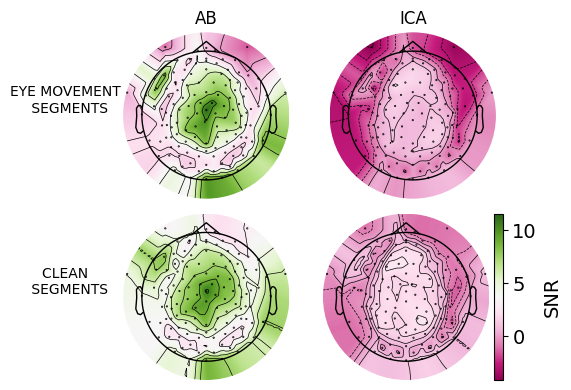

In [20]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(6,4))

df_snr_saccade = df_snr.loc[df_snr['seg_type']=='saccade']
df_snr_saccade = df_snr_saccade.groupby(['channel', 'kind']).mean('snr').reset_index()

vmin = df_snr_saccade['snr'].min()
vmax = df_snr_saccade['snr'].max()


df_snr_saccade_ab = df_snr_saccade.loc[df_snr_saccade['kind']=='AB']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_saccade_ab['channel'], df_snr_saccade_ab['snr']))
channel_names = list(df_snr_saccade_ab.channel)
plot_values_topomap(dict_topomap, montage,ax0,mask=None, mask_params=None, colorbar=False,vmin=vmin,vmax=vmax)
ax0.set_title('AB')
ax0.set_ylabel('EYE MOVEMENT \n SEGMENTS', labelpad=40, rotation = 'horizontal',fontsize=10, loc='center')

df_snr_saccade_ica = df_snr_saccade.loc[df_snr_saccade['kind']=='ICA']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_saccade_ica['channel'], df_snr_saccade_ica['snr']))
channel_names = list(df_snr_saccade_ica.channel)
plot_values_topomap(dict_topomap, montage, ax1,mask=None, mask_params=None,colorbar=False,vmin=vmin,vmax=vmax)
ax1.set_title('ICA')

df_snr_clean = df_snr.loc[df_snr['seg_type']=='clean']
df_snr_clean = df_snr_clean.groupby(['channel', 'kind']).mean('snr').reset_index()

df_snr_clean_ab = df_snr_clean.loc[df_snr_clean['kind']=='AB']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_clean_ab['channel'], df_snr_clean_ab['snr']))
channel_names = list(df_snr_clean_ab.channel)
plot_values_topomap(dict_topomap, montage, ax2, mask=None, mask_params=None,colorbar=False,vmin=vmin,vmax=vmax)
ax2.set_ylabel('CLEAN \n SEGMENTS', labelpad=40, rotation = 'horizontal',fontsize=10, loc='center')

df_snr_clean_ica = df_snr_clean.loc[df_snr_clean['kind']=='ICA']
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
dict_topomap = dict(zip(df_snr_clean_ica['channel'], df_snr_clean_ica['snr']))
channel_names = list(df_snr_clean_ica.channel)
plot_values_topomap(dict_topomap, montage, ax3, mask=None, mask_params=None,colorbar=True,cbar_title='SNR',vmin=vmin,vmax=vmax)

fig.tight_layout()
plt.savefig('fig4.png', dpi=300)

## Statistical analysis

In [21]:
montage = mne.channels.make_standard_montage(kind='GSN-HydroCel-129')
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [22]:
adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


#### Eye movement segments

In [37]:
df_snr_saccade = df_snr.loc[df_snr['seg_type']=='saccade']
df_snr_saccade = df_snr_saccade.groupby(['subject','channel', 'kind']).mean('snr').reset_index()

df_snr_saccade_ab = df_snr_saccade.loc[df_snr_saccade['kind']=='AB']
df_snr_saccade_ab = df_snr_saccade_ab[['snr', 'subject', 'channel']]
df_snr_saccade_ab = df_snr_saccade_ab.pivot_table(index='subject', columns='channel', values='snr')

snr_saccade_array_ab = np.array(df_snr_saccade_ab)

In [38]:
df_snr_saccade_ica = df_snr_saccade.loc[df_snr_saccade['kind']=='ICA']
df_snr_saccade_ica = df_snr_saccade_ica[['snr', 'subject', 'channel']]
df_snr_saccade_ica = df_snr_saccade_ica.pivot_table(index='subject', columns='channel', values='snr')

snr_saccade_array_ica = np.array(df_snr_saccade_ica)

In [39]:
X_saccade = np.array([snr_saccade_array_ab, snr_saccade_array_ica])

In [40]:
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]

In [41]:
w, clusters_sacc, clusters_pv_sacc, h0 = mne.stats.permutation_cluster_test(X_saccade, threshold=1/434, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun,
                                                                  adjacency=adj_matrix)

stat_fun(H1): min=0.002907 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_3594/3453851328.py:2: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

#### Clean segments

In [42]:
df_snr_clean = df_snr.loc[df_snr['seg_type']=='saccade']
df_snr_clean = df_snr_clean.groupby(['subject','channel', 'kind']).mean('snr').reset_index()

df_snr_clean_ab = df_snr_clean.loc[df_snr_clean['kind']=='AB']
df_snr_clean_ab = df_snr_clean_ab[['snr', 'subject', 'channel']]
df_snr_clean_ab = df_snr_clean_ab.pivot_table(index='subject', columns='channel', values='snr')

snr_clean_array_ab = np.array(df_snr_clean_ab)

df_snr_clean_ica = df_snr_clean.loc[df_snr_clean['kind']=='ICA']
df_snr_clean_ica = df_snr_clean_ica[['snr', 'subject', 'channel']]
df_snr_clean_ica = df_snr_clean_ica.pivot_table(index='subject', columns='channel', values='snr')

snr_clean_array_ica = np.array(df_snr_clean_ica)

X_clean = np.array([snr_clean_array_ab, snr_clean_array_ica])

w, clusters_clean, clusters_pv_clean, h0 = mne.stats.permutation_cluster_test(X_clean, threshold=1/434, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun,
                                                                  adjacency=adj_matrix)

stat_fun(H1): min=0.002907 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_3594/3453851328.py:2: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

#### Topomaps with clusters

In [28]:
mask_params = dict(markersize=5, markerfacecolor="y")

In [44]:
significant_channels = []
significant_channels.extend(clusters_sacc[0])
    
significant_channels = sorted(significant_channels)

mask_sacc = np.zeros((129,),dtype='bool')
for ch in significant_channels:
    mask_sacc[ch] = True

In [43]:
significant_channels = []
significant_channels.extend(clusters_clean[0])
    
significant_channels = sorted(significant_channels)

mask_clean = np.zeros((129,),dtype='bool')
for ch in significant_channels:
    mask_clean[ch] = True

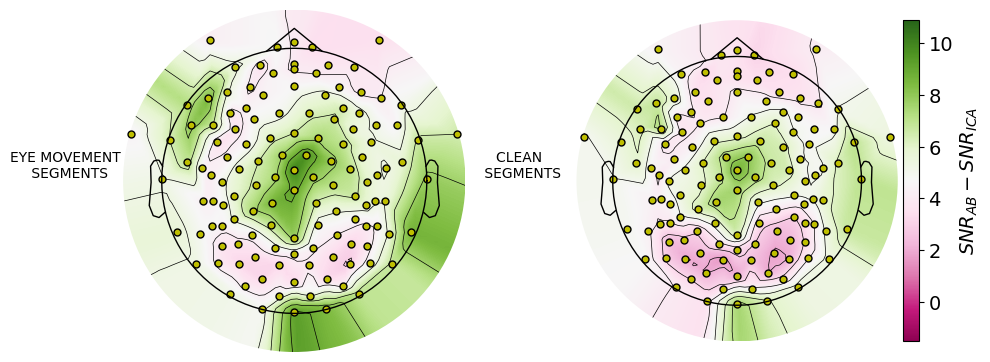

In [51]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_snr_saccade = df_snr.loc[df_snr['seg_type']=='saccade']
df_snr_saccade = df_snr_saccade.groupby(['channel', 'kind']).mean('snr').reset_index()

vmin = df_snr_saccade['snr'].min()
vmax = df_snr_saccade['snr'].max()


df_snr_saccade_ab = df_snr_saccade.loc[df_snr_saccade['kind']=='AB']
df_snr_saccade_ab = df_snr_saccade_ab.pivot_table(index=["channel"], columns="kind", values="snr")
snr_ab = df_snr_saccade_ab['AB']

df_snr_saccade_ica = df_snr_saccade.loc[df_snr_saccade['kind']=='ICA']
df_snr_saccade_ica = df_snr_saccade_ica.pivot_table(index=["channel"], columns="kind", values="snr")
snr_ica = df_snr_saccade_ica['ICA']

diff_snr = (snr_ab - snr_ica).abs()
diff_snr.name = 'diff_snr'
diff_snr = diff_snr.reset_index()

dict_topomap = dict(zip(diff_snr['channel'], diff_snr['diff_snr']))
plot_values_topomap(dict_topomap, montage,ax[0],mask=mask_sacc, mask_params=mask_params, colorbar=False,vmin=vmin,vmax=vmax)
ax[0].set_ylabel('EYE MOVEMENT \n SEGMENTS', labelpad=40, rotation = 'horizontal',fontsize=10, loc='center')

df_snr_clean = df_snr.loc[df_snr['seg_type']=='clean']
df_snr_clean = df_snr_clean.groupby(['channel', 'kind']).mean('snr').reset_index()

vmin = df_snr_clean['snr'].min()
vmax = df_snr_clean['snr'].max()

df_snr_clean_ab = df_snr_clean.loc[df_snr_clean['kind']=='AB']
df_snr_clean_ab = df_snr_clean_ab.pivot_table(index=["channel"], columns="kind", values="snr")
snr_ab = df_snr_clean_ab['AB']

df_snr_clean_ica = df_snr_clean.loc[df_snr_clean['kind']=='ICA']
df_snr_clean_ica = df_snr_clean_ica.pivot_table(index=["channel"], columns="kind", values="snr")
snr_ica = df_snr_clean_ica['ICA']

diff_snr = (snr_ab - snr_ica).abs()
diff_snr.name = 'diff_snr'
diff_snr = diff_snr.reset_index()

dict_topomap = dict(zip(diff_snr['channel'], diff_snr['diff_snr']))
plot_values_topomap(dict_topomap, montage,ax[1],mask=mask_clean, mask_params=mask_params, colorbar=True,vmin=vmin,vmax=vmax, cbar_title='$SNR_{AB} - SNR_{ICA}$')
ax[1].set_ylabel('CLEAN \n SEGMENTS', labelpad=40, rotation = 'horizontal',fontsize=10, loc='center')

fig.tight_layout()
plt.savefig('figS1.png', dpi=300)

(<matplotlib.image.AxesImage at 0x2bb11a710>,
 <matplotlib.contour.QuadContourSet at 0x2baee2690>)

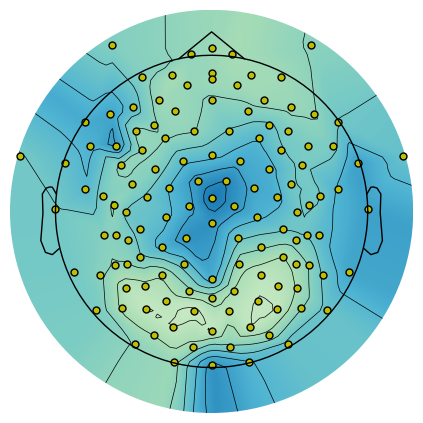